In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.metrics import classification_report, log_loss, accuracy_score


import xgboost as xgb
from xgboost import plot_importance

In [20]:
ticker = "AAPL"


df = pd.read_csv(
    f"csv/{ticker}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date format
) 


In [21]:
def calculate_target(df, window=5, profit_take_pct=2.0, stop_loss_pct=1.0):
    """
    Calcola le etichette binarie (0 o 1) basandosi sul metodo a due barriere.

    Args:
        df (pd.DataFrame): DataFrame con i dati di prezzo (deve contenere 'Close', 'High', 'Low').
        window (int): L'orizzonte temporale massimo in giorni per raggiungere una barriera.
        profit_take_pct (float): La soglia percentuale per la barriera di profitto.
        stop_loss_pct (float): La soglia percentuale per la barriera di stop-loss.

    Returns:
        pd.Series: Una serie di etichette (0, 1) o NaN se non ci sono dati futuri.
    """
    
    targets = []
    
    # Converti le percentuali in moltiplicatori
    profit_multiplier = 1 + (profit_take_pct / 100)
    stop_multiplier = 1 - (stop_loss_pct / 100)

    for i in range(len(df)):
        # Controlla se ci sono abbastanza dati futuri per la finestra
        if i + window >= len(df):
            targets.append(np.nan)
            continue

        start_price = df['Close'].iloc[i]
        
        # Calcola le barriere per questo specifico punto di partenza
        upper_barrier = start_price * profit_multiplier
        lower_barrier = start_price * stop_multiplier
        
        target_label = 0  # Default: consideriamo un timeout come una non-vittoria (0)
        
        # Ciclo sui giorni futuri per vedere quale barriera viene toccata prima
        for j in range(1, window + 1):
            future_high = df['High'].iloc[i + j]
            future_low = df['Low'].iloc[i + j]
            
            # 1. Controlla se la barriera di profitto è stata raggiunta
            if future_high >= upper_barrier:
                target_label = 1
                break  # Esci dal ciclo interno, abbiamo un vincitore!
            
            # 2. Controlla se la barriera di stop-loss è stata raggiunta
            if future_low <= lower_barrier:
                target_label = 0
                break  # Esci dal ciclo interno, abbiamo un perdente!
        
        # Se il ciclo finisce senza un 'break', l'etichetta rimane il default (0)
        targets.append(target_label)
        
    return pd.Series(targets, index=df.index)


# --- Come usarla nel tuo codice (sostituisci la parte di calcolo del target) ---

# Applica la nuova funzione
# Puoi facilmente sperimentare con diverse soglie e finestre


df['Target'] = calculate_target(df, window=5, profit_take_pct=2.0, stop_loss_pct=1.0)
df = df.dropna(subset=["Target"])
df['Target'] = df['Target'].astype(int) # Converte in intero

tag_counts = df["Target"].value_counts()
print(f"  Conteggio etichette:")
print(tag_counts)
print(f"  Totale righe: {len(df)}")
print("-" * 40)



  Conteggio etichette:
Target
0    993
1    711
Name: count, dtype: int64
  Totale righe: 1704
----------------------------------------


In [22]:
features = ["High","Volume","Return","MACD","MACD_Signal",
            "MACD_Hist","EMA20","Vol_EMA20",
            "RSI","Boll_Up","Boll_Down","Dist_low_band",
            "Dist_up_band","%K","%D","R_EMA20","ADX","+DI",
            "-DI","ATR","BB_pctB","ROC","OBV","CMF",
            "MACD_norm","RSI_diff","DI_diff","SMA_slope",
            "RSI_slope","MACD_slope","%K_slope","%D_slope",
            "ATR_slope","OBV_slope","ADX_slope","RSI_overbought",
            "RSI_oversold","Stoch_overbought","Stoch_oversold",
            "MACD_crossover_signal","Vol_pct_change","RSI_x_Vol_Change",
            "ATR_pct","RSI_SMA15","RSI_vs_SMA","MACD_Hist_Std20",
            "SP_Return","SP_RSI","SP_Dist_SMA"]


X = df[features]
y = df["Target"]


len(features)

49

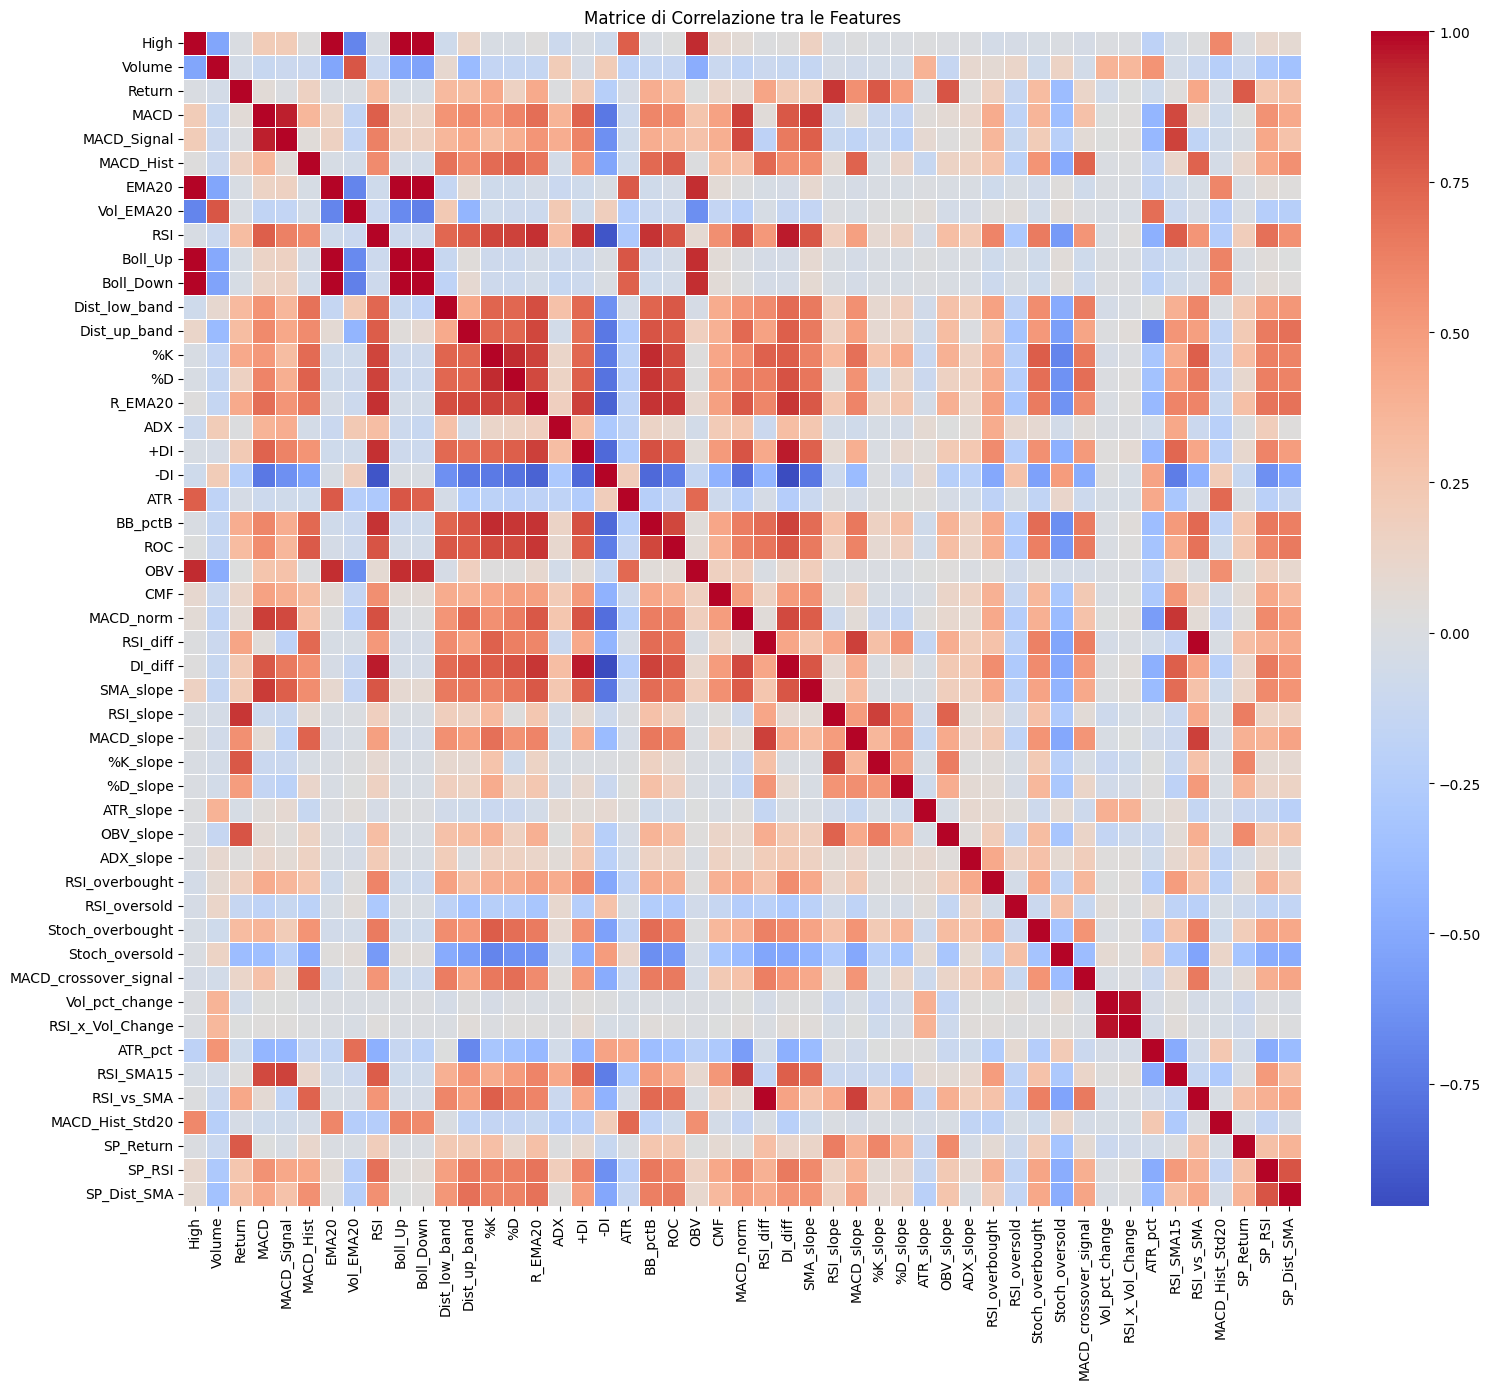


--- Coppie di Feature Altamente Correlate (> 0.9) ---
              Indice_A          Indice_B  Correlation
303              EMA20           Boll_Up     0.998436
447            Boll_Up             EMA20     0.998436
496          Boll_Down             EMA20     0.997861
304              EMA20         Boll_Down     0.997861
2181        RSI_vs_SMA          RSI_diff     0.997786
1269          RSI_diff        RSI_vs_SMA     0.997786
6                 High             EMA20     0.997022
294              EMA20              High     0.997022
9                 High           Boll_Up     0.995034
441            Boll_Up              High     0.995034
451            Boll_Up         Boll_Down     0.993609
499          Boll_Down           Boll_Up     0.993609
10                High         Boll_Down     0.993315
490          Boll_Down              High     0.993315
2049  RSI_x_Vol_Change    Vol_pct_change     0.975329
2001    Vol_pct_change  RSI_x_Vol_Change     0.975329
859                +DI     

In [23]:
correlation_matrix = df[features].corr()

plt.figure(figsize=(16, 14)) # Rendi la figura grande per leggibilità
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matrice di Correlazione tra le Features")
plt.tight_layout()
plt.show()

# Potresti anche stampare le coppie più correlate
# Crea un DataFrame pulito della matrice di correlazione
corr_df = correlation_matrix.stack().reset_index()
corr_df.columns = ["Indice_A", "Indice_B", "Correlation"]
# Filtra per correlazioni alte (escludendo la correlazione di una feature con se stessa)
high_corr_pairs = corr_df[
    (corr_df["Correlation"].abs() > 0.9) & (corr_df["Indice_A"] != corr_df["Indice_B"])
]
print("\n--- Coppie di Feature Altamente Correlate (> 0.9) ---")
print(high_corr_pairs.sort_values(by="Correlation", ascending=False))


=== Mutual Information Score Ranking ===
                  Feature  MI_Score
9                 Boll_Up  0.033332
8                     RSI  0.029999
19                    ATR  0.024974
12           Dist_up_band  0.024195
22                    OBV  0.023715
0                    High  0.020390
15                R_EMA20  0.019649
16                    ADX  0.015944
30               %K_slope  0.015489
10              Boll_Down  0.015268
42                ATR_pct  0.014094
23                    CMF  0.012212
6                   EMA20  0.012079
44             RSI_vs_SMA  0.011411
34              ADX_slope  0.008769
13                     %K  0.008646
11          Dist_low_band  0.008254
47                 SP_RSI  0.007511
7               Vol_EMA20  0.007047
28              RSI_slope  0.006140
5               MACD_Hist  0.005391
26                DI_diff  0.005205
20                BB_pctB  0.005052
37       Stoch_overbought  0.004233
32              ATR_slope  0.004178
33              OBV_sl

/tmp/ipykernel_1021/2095689325.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="MI_Score", y="Feature", data=mi_df.head(20), palette="viridis")


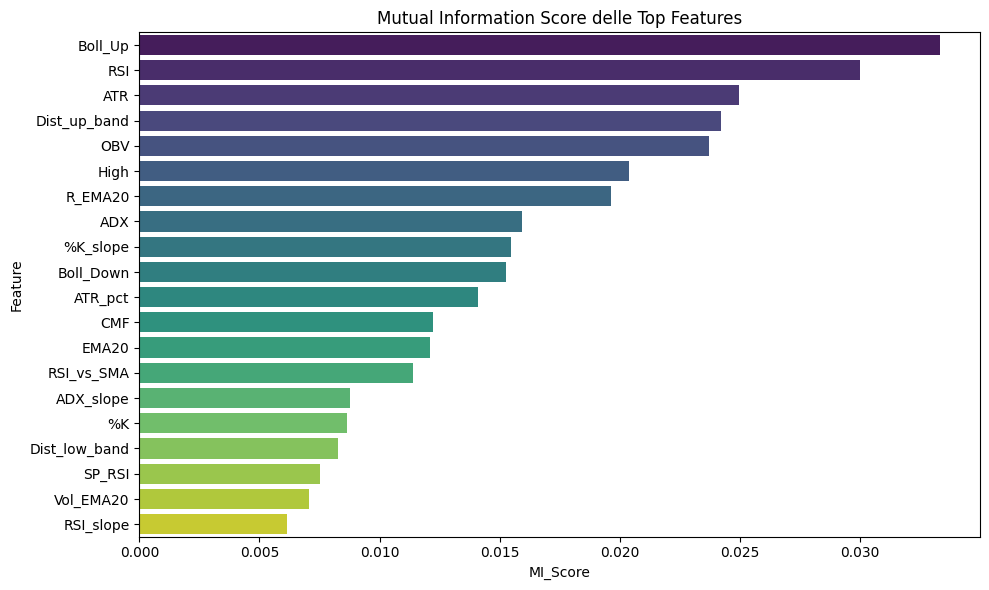

In [24]:
from sklearn.feature_selection import mutual_info_classif

# Mutual Information Score
# Misura la dipendenza tra due variabili. Un valore più alto significa maggiore dipendenza.
# Può catturare relazioni non lineari.

# C'è bisogno che y siano dei numeri. Usiamo y = df[y_label].astype("category").cat.codes  da prima

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    "Feature": features,
    "MI_Score": mi_scores
}).sort_values("MI_Score", ascending=False)

print("\n=== Mutual Information Score Ranking ===")
print(mi_df)

# Visualizzazione
plt.figure(figsize=(10, 6))
sns.barplot(x="MI_Score", y="Feature", data=mi_df.head(20), palette="viridis")
plt.title("Mutual Information Score delle Top Features")
plt.tight_layout()
plt.show()

In [25]:

# --- 1. NUOVA DIVISIONE CRONOLOGICA IN TRE SET ---
# 70% Train, 15% Validation, 15% Test
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print(f"Dimensioni set: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")

# Converti in DMatrix una sola volta
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val) # Il validation set per il tuning
dtest = xgb.DMatrix(X_test, label=y_test) # Il test set per la valutazione finale



Dimensioni set: Train=1192, Validation=255, Test=257


neg, pos = np.sum(y_train == 0), np.sum(y_train == 1)

params = {
    'eta': 0.017080169548574973,
    'max_depth': 4,
    'lambda': 2.533879054772994,
    'alpha': 0.3407408557190542,
    'subsample': 0.7416903507359404,
    'colsample_bytree': 0.6779017456324347,
    'gamma': 0.394863463786954,
    'scale_pos_weight': 1.510412367942961,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
}

num_rounds = 800 # number of max boosting iterations

# Train with evaluation for each iteration
evals = [(dtrain,"train"),(dval, 'validation')]
evals_result = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False,
    early_stopping_rounds=11
)

# Plot the Loss Curve
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['validation']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label='Train Log Loss', linewidth=2)
plt.plot(val_logloss, label='Validation Log Loss', linewidth=2)
plt.xlabel('Boosting Round', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.title('XGBoost Log Loss Progression (Tuned Model)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest iteration: {model.best_iteration}")
print(f"Number of boosting rounds used: {len(train_logloss)}")

# Final Evaluation
y_pred_proba = model.predict(dtest)
best_mcc = -1
best_threshold = 0.5
for threshold in np.arange(0.1, 0.9, 0.01):
    preds = (y_pred_proba > threshold).astype(int)
    mcc = matthews_corrcoef(y_test, preds)
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

y_pred = (y_pred_proba >= best_threshold).astype(int)

print("\n" + "="*60)
print(f"FINAL MODEL EVALUATION: best threshold: {best_threshold}")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=[1, 0]))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Final Validation Log Loss: {log_loss(y_test, y_pred_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (XGBoost - Tuned)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [26]:
num_rounds = 800
early_stop = 10

In [27]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- 2. TUNING CON OPTUNA (USANDO TRAIN E VALIDATION) ---
pos_weight = np.sum(y_train == 0) / max(np.sum(y_train == 1), 1)

def objective(trial: optuna.trial.Trial) -> float:
    params_trial = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'lambda': trial.suggest_float('lambda', 0.1, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 0.1, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 5.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.9 * pos_weight, 1.1 * pos_weight),
        'random_state': 42,
    }



    # NOTA: Ora usiamo dval (il validation set) per la valutazione nel tuning
    model = xgb.train(
        params=params_trial,
        dtrain=dtrain,
        num_boost_round=num_rounds,
        evals=[(dval, 'validation')],
        early_stopping_rounds=early_stop,
        verbose_eval=False
    )
    
    # Previsioni sul validation set
    preds_proba = model.predict(dval, iteration_range=(0, model.best_iteration))
    
    # L'obiettivo di Optuna è ottimizzato sul validation set
    auc = roc_auc_score(y_val, preds_proba)
    return float(1.0 - auc)

print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='minimize', study_name='xgboost_tuning')
study.optimize(objective, n_trials=100, show_progress_bar=True)

best_params = study.best_params


/home/samu/MarGui-Project2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting hyperparameter optimization with Optuna...


Best trial: 58. Best value: 0.433868: 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42, 'booster': 'gbtree', 'eta': 0.1417544315471703, 'max_depth': 4, 'lambda': 1.930046091151565, 'alpha': 6.80774553453947, 'subsample': 0.8187288387849558, 'colsample_bytree': 0.8835241369213169, 'gamma': 3.1163785812510834, 'scale_pos_weight': 1.3229644035966752}

Training final model with best hyperparameters...


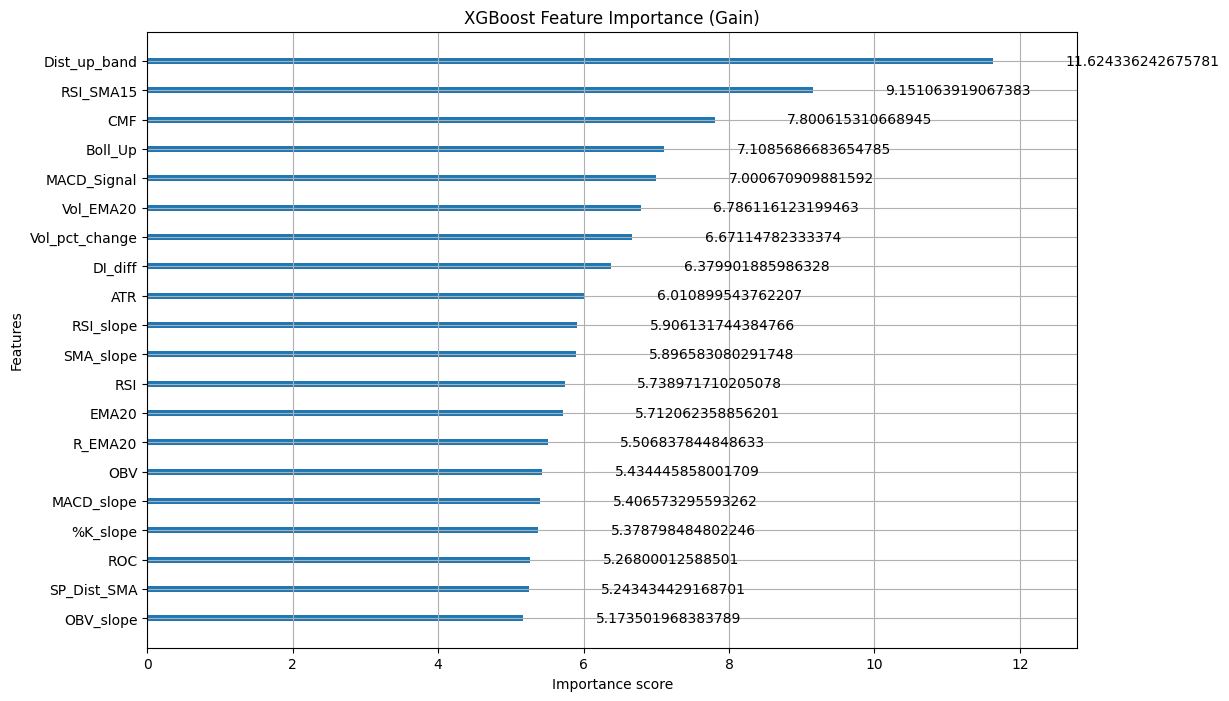

{'High': 4.266010284423828, 'Volume': 3.671957492828369, 'MACD_Signal': 7.000670909881592, 'MACD_Hist': 4.823248863220215, 'EMA20': 5.712062358856201, 'Vol_EMA20': 6.786116123199463, 'RSI': 5.738971710205078, 'Boll_Up': 7.1085686683654785, 'Dist_low_band': 4.980343818664551, 'Dist_up_band': 11.624336242675781, 'R_EMA20': 5.506837844848633, 'ADX': 3.418980121612549, '-DI': 5.097655296325684, 'ATR': 6.010899543762207, 'ROC': 5.26800012588501, 'OBV': 5.434445858001709, 'CMF': 7.800615310668945, 'MACD_norm': 4.468904972076416, 'RSI_diff': 3.4602622985839844, 'DI_diff': 6.379901885986328, 'SMA_slope': 5.896583080291748, 'RSI_slope': 5.906131744384766, 'MACD_slope': 5.406573295593262, '%K_slope': 5.378798484802246, '%D_slope': 5.163487434387207, 'OBV_slope': 5.173501968383789, 'ADX_slope': 4.484659671783447, 'Vol_pct_change': 6.67114782333374, 'RSI_x_Vol_Change': 4.802974700927734, 'ATR_pct': 5.072879791259766, 'RSI_SMA15': 9.151063919067383, 'MACD_Hist_Std20': 5.002790927886963, 'SP_Return'

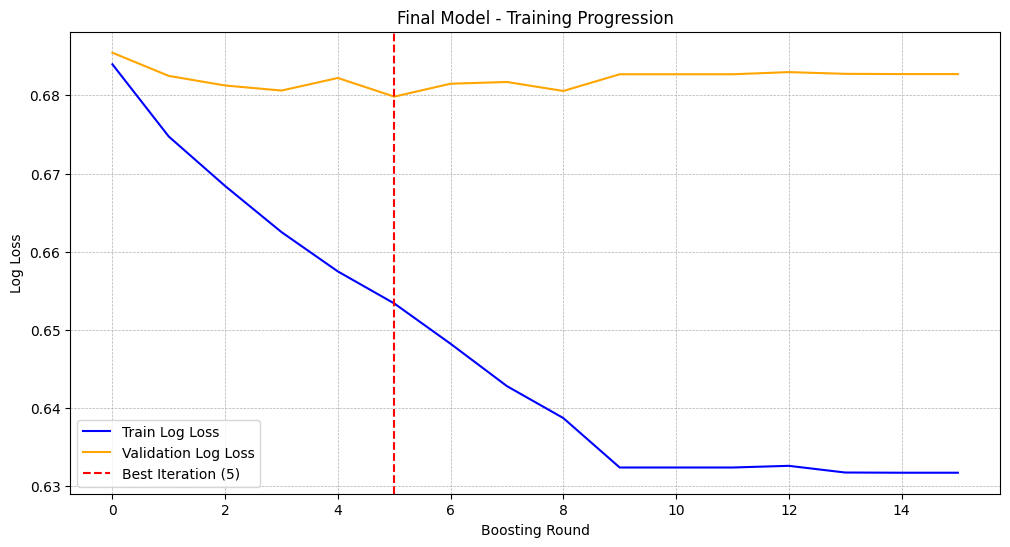

Optimizing probability threshold on VALIDATION set...
Best threshold found: 0.53 with MCC: 0.1280
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
    'booster': 'gbtree',
    'eta': 0.1417544315471703,
    'max_depth': 4,
    'lambda': 1.930046091151565,
    'alpha': 6.80774553453947,
    'subsample': 0.8187288387849558,
    'colsample_bytree': 0.8835241369213169,
    'gamma': 3.1163785812510834,
    'scale_pos_weight': 1.3229644035966752,
}

FINAL MODEL EVALUATION ON UNSEEN TEST SET

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.56      0.10      0.17       102
           0       0.62      0.95      0.75       155

    accuracy                           0.61       257
   macro avg       0.59      0.52      0.46       257
weighted avg       0.59      0.61      0.52       257


Accuracy (Test Set): 0.6109
Matthews Corr Coef (Test Set): 0.0890
Log Loss (Test Set): 0.6862


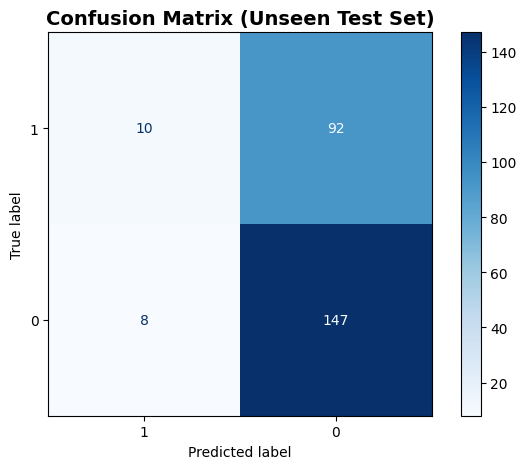

  Conteggio etichette:
Target
0    155
1    102
Name: count, dtype: int64
  Totale righe: 1704
----------------------------------------


In [29]:
evals_result = {}
base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
    'booster': 'gbtree'
}

final_params = {**base_params, **best_params}

# final_params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'random_state': 42,
#     'booster': 'gbtree',
#     'eta': 0.03155121459353578,
#     'max_depth': 2,
#     'lambda': 1.0784099148463868,
#     'alpha': 0.42234212397967985,
#     'subsample': 0.6299416538834441,
#     'colsample_bytree': 0.8496725760030435,
#     'gamma': 3.8323601626718347,
#     'scale_pos_weight': 1.2503463245653215,
# }


print(final_params)

# --- 3. TRAINING DEL MODELLO FINALE E VALUTAZIONE ---
print("\nTraining final model with best hyperparameters...")
# Addestriamo il modello finale con i parametri trovati

final_model = xgb.train(
    params=final_params,
    dtrain=dtrain,
    evals_result = evals_result,
    num_boost_round=num_rounds,
    evals=[(dtrain, 'train'),(dval, 'validation')], # Usiamo ancora la validazione per l'early stopping
    early_stopping_rounds=early_stop,
    verbose_eval=False
)


# Plotta la feature importance
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(final_model, ax=ax, max_num_features=20, importance_type='gain') 
# importance_type può essere 'weight', 'gain', 'cover'.
plt.title('XGBoost Feature Importance (Gain)')
plt.show()

# Puoi anche ottenere i dati in formato dizionario
importance = final_model.get_score(importance_type='gain')
print(importance)


# --- STAMPA DEL GRAFICO DELLA LOSS ---

# Estrai i valori di loss dal dizionario popolato
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['validation']['logloss']

# Crea il grafico
plt.figure(figsize=(12, 6))
plt.plot(train_logloss, label='Train Log Loss', color='blue')
plt.plot(val_logloss, label='Validation Log Loss', color='orange')

# Aggiungi una linea verticale per mostrare dove si è fermato l'addestramento
plt.axvline(x=final_model.best_iteration, color='red', linestyle='--', 
            label=f'Best Iteration ({final_model.best_iteration})')

plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('Final Model - Training Progression')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# --- 4. OTTIMIZZAZIONE DELLA SOGLIA (SUL VALIDATION SET!) ---
print("Optimizing probability threshold on VALIDATION set...")
y_pred_proba_val = final_model.predict(dval, iteration_range=(0, final_model.best_iteration))
best_mcc = -1
best_threshold = 0.5
for threshold in np.arange(0.1, 0.9, 0.01):
    preds = (y_pred_proba_val > threshold).astype(int)
    mcc = matthews_corrcoef(y_val, preds)
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

print(f"Best threshold found: {best_threshold:.2f} with MCC: {best_mcc:.4f}")
print("="*60)
print("params = {")
for k, v in final_params.items():
    print(f"    '{k}': {repr(v)},")
print("}")
print("="*60)

# --- 5. VALUTAZIONE FINALE E ONESTA (SUL TEST SET!) ---
print("\n" + "="*60)
print(f"FINAL MODEL EVALUATION ON UNSEEN TEST SET")
print("="*60)

# Usiamo il modello finale e la soglia trovata per fare previsioni sul dtest
y_pred_proba_test = final_model.predict(dtest, iteration_range=(0, final_model.best_iteration))
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, labels=[1, 0]))

print(f"\nAccuracy (Test Set): {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Matthews Corr Coef (Test Set): {matthews_corrcoef(y_test, y_pred_test):.4f}")
print(f"Log Loss (Test Set): {log_loss(y_test, y_pred_proba_test):.4f}")

# Confusion Matrix sul test set
cm = confusion_matrix(y_test, y_pred_test, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Unseen Test Set)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


tag_counts = y_test.value_counts()
print(f"  Conteggio etichette:")
print(tag_counts)
print(f"  Totale righe: {len(df)}")
print("-" * 40)


# Export model code
import joblib

SavedName = f"rf_{TICKER}_v1.joblib"

# Selezionare la variabile del modello da estrarre
bundle = {
    "model": rf,
    # add scaler if needed "scaler": scaler
    "features": features 
}
#joblib.dump(bundle, f"models/{SavedName}")

